<a href="https://colab.research.google.com/github/ilham-ap/seminar/blob/main/seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title **Download datasets** { vertical-output: true, display-mode: "form" }
%%capture
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1OHJq8LLedlUZZSYrrXRUbXsFWO50D4am
!unzip 'seminar.zip'

In [3]:
#@title **Install requirements** { vertical-output: true, display-mode: "form" }
%%capture
!pip install einops
!pip install patchify

In [4]:
#@title **Import requirements** { vertical-output: true, display-mode: "form" }
import torch
import argparse
import torch.nn as nn
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
from scipy.io import loadmat
from scipy.io import savemat
from torch import optim
from torch.autograd import Variable
from sstvit import SSTViT
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from patchify import patchify, unpatchify
import time
import os
from matplotlib import colors as mcolors

In [5]:
#@title **Function** { vertical-output: true, display-mode: "form" }
class Args(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__

args = {
    'dataset' : 'mg',
    'flag_test' : 'train',
    'gpu_id' : 0,
    'seed' : int(0),
    'batch_size' : int(64),
    'test_freq' : int(10),
    'patches' : int(5),
    'band_patches' : int(1),
    'epoches' : int(2000),
    'learning_rate' : float(5e-4),
    'gamma' : float(0.9),
    'weight_decay' : float(0),
    'train_number' : int(500)
}
args = Args(args) # dict2object
obj = args.copy() # object2dict

os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)

def test_epoch(model, test_loader):

    pre = np.array([])
    for batch_idx, (batch_data_t1, batch_data_t2) in enumerate(test_loader):
        batch_data_t1 = batch_data_t1.cuda()
        batch_data_t2 = batch_data_t2.cuda()

        batch_pred = model(batch_data_t1,batch_data_t2)

        _, pred = batch_pred.topk(1, 1, True, True)
        pp = pred.squeeze()
        pre = np.append(pre, pp.data.cpu().numpy())
    return pre
mdic = ['Before','After','Before','After']
colors = ['#3b68f8', '#ff0201', '#23fe01'] #-1,0,1,2,3
cmap = mcolors.ListedColormap(colors)
# Parameter Setting
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

In [9]:
#@title **Load datasets** { vertical-output: true, display-mode: "form" }
data_t1 = loadmat('datasets/pre_sf.mat')['pre']
data_t2 = loadmat('datasets/post_sf.mat')['post']
L_post = np.load('datasets/linknet_sf1.npy')
L_pre = np.load('datasets/linknet_sf2.npy')
data_img1 = loadmat('datasets/RGBhisteq_sf1.mat')['B']
data_img2 = loadmat('datasets/RGBhisteq_sf2.mat')['A']

In [10]:
#@title **Data pre-processing** { vertical-output: true, display-mode: "form" }
L_post = np.double(L_post)
L_post[L_post==0]=-0.8
L_post[L_post==1]=0
L_post[L_post==0]=-0.2

L_pre = np.double(L_pre)
L_pre[L_pre==0]=-0.8
L_pre[L_pre==1]=0
L_pre[L_pre==0]=-0.2


data_t1 = data_t1[:L_post.shape[0],:L_post.shape[1],:]
data_t2 = data_t2[:L_post.shape[0],:L_post.shape[1],:]
data_cb1 = np.zeros(shape=(L_post.shape[0],L_post.shape[1],11),dtype=np.float32)
data_cb2 = np.zeros(shape=(L_post.shape[0],L_post.shape[1],11),dtype=np.float32)
data_cb1[:,:,:10]=data_t1
data_cb1[:,:,10]=L_pre
data_cb2[:,:,:10]=data_t2
data_cb2[:,:,10]=L_post
height, width, band = data_cb1.shape
height=height-4
width = width-4
x1 = patchify(data_cb1, (5, 5, 11), step=1).reshape(-1,5*5, 11)
x2 = patchify(data_cb2, (5, 5, 11), step=1).reshape(-1,5*5, 11)

In [11]:
#@title **Model** { vertical-output: true, display-mode: "form" }
model = SSTViT(
    image_size = 5,
    near_band = args.band_patches,
    num_patches = 11,
    num_classes = 3,
    dim = 32,
    depth = 2,
    heads = 4,
    dim_head=16,
    mlp_dim = 8,
    b_dim = 512,
    b_depth = 3,
    b_heads = 8,
    b_dim_head= 32,
    b_mlp_head = 8,
    dropout = 0.2,
    emb_dropout = 0.1,
)

model = model.cuda()
model.load_state_dict(torch.load("model/lsstformer.pth"))

<All keys matched successfully>

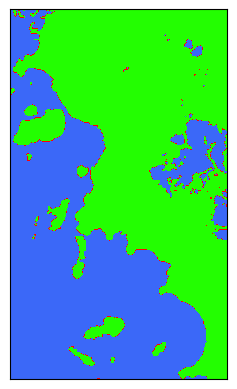

Process: 63.736900806427


In [15]:
#@title **Prediction before** { vertical-output: true, display-mode: "form" }
start = time.time()
x1_true_band=torch.from_numpy(x1.transpose(0,2,1)).type(torch.FloatTensor)
x2_true_band=torch.from_numpy(x1.transpose(0,2,1)).type(torch.FloatTensor)
Label_true=Data.TensorDataset(x1_true_band,x2_true_band)
label_true_loader=Data.DataLoader(Label_true,batch_size=100,shuffle=False)
model.eval()
# output classification maps
pre_u = test_epoch(model, label_true_loader)
prediction_matrix = pre_u.reshape(height,width)
plt.subplot(1,1,1)
plt.imshow(prediction_matrix, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()
end = time.time()
process = end-start
print('Process:', process,'s')

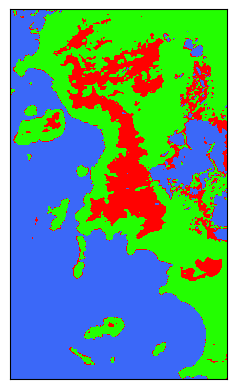

Process: 62.39782452583313 s


In [16]:
#@title **Prediction after** { vertical-output: true, display-mode: "form" }
start = time.time()
x1_true_band=torch.from_numpy(x1.transpose(0,2,1)).type(torch.FloatTensor)
x2_true_band=torch.from_numpy(x2.transpose(0,2,1)).type(torch.FloatTensor)
Label_true=Data.TensorDataset(x1_true_band,x2_true_band)
label_true_loader=Data.DataLoader(Label_true,batch_size=100,shuffle=False)
model.eval()
# output classification maps
pre_u = test_epoch(model, label_true_loader)
prediction_matrix2 = pre_u.reshape(height,width)
plt.subplot(1,1,1)
plt.imshow(prediction_matrix2, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()
end = time.time()
process = end-start
print('Process:', process,'s')

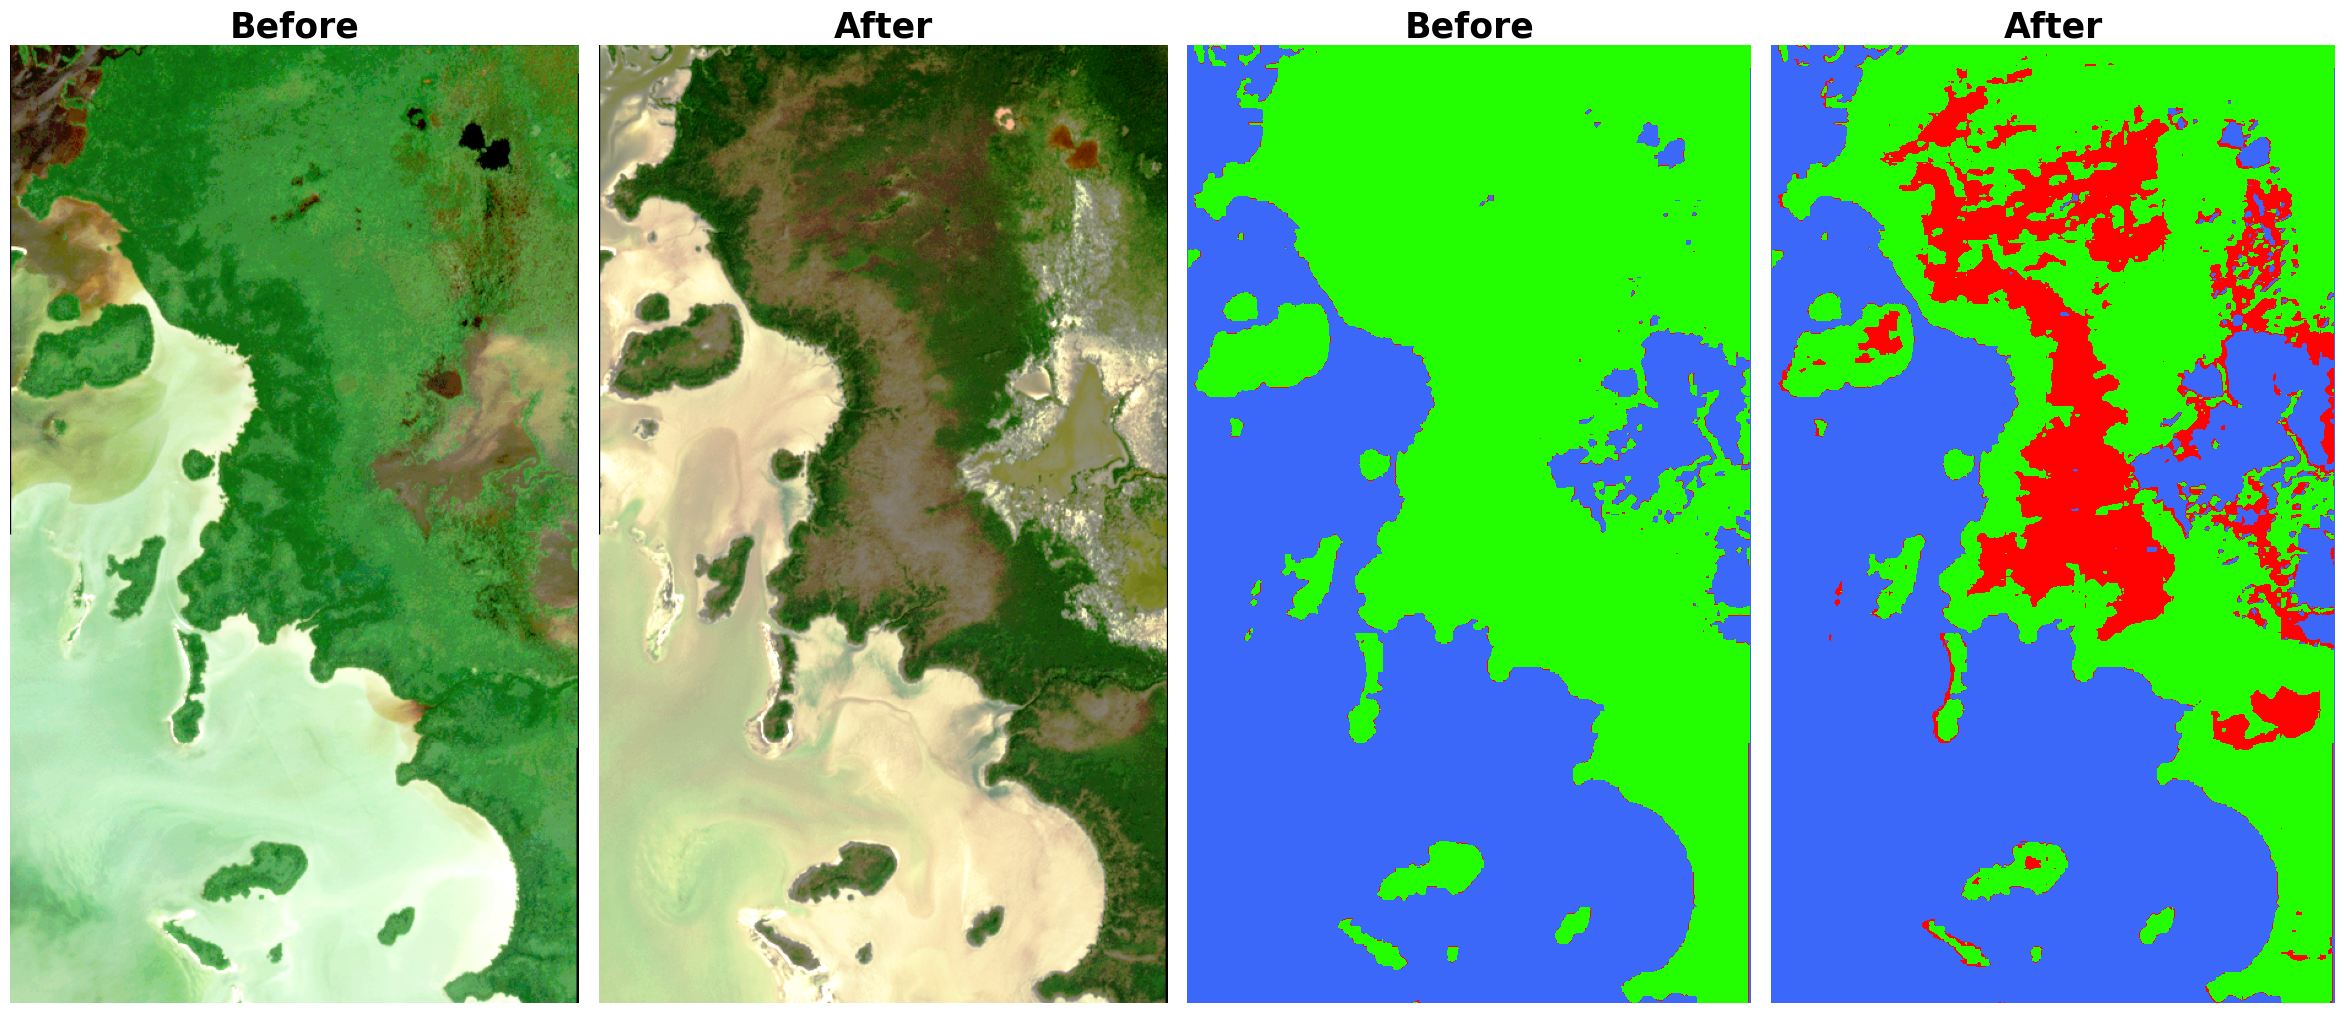

In [17]:
#@title **Visualization** { vertical-output: true, display-mode: "form" }
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
from matplotlib import colors as mcolors
mdic = ['Before','After','Before','After']
colors = ['#3b68f8', '#ff0201', '#23fe01'] #-1,0,1,2,3
cmap = mcolors.ListedColormap(colors)
fig = plt.figure(figsize=(30, 30))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 4),
                axes_pad=0.2,
                #cbar_mode='single',
                #cbar_location='right',
                #cbar_pad=0.1
                )
i=0
for ax in grid:
    if i==0:
        ax.set_axis_off()
        im = ax.imshow(data_img2)
    elif i==1:
        ax.set_axis_off()
        im = ax.imshow(data_img1)
    elif i==2:
        ax.set_axis_off()
        im = ax.imshow(prediction_matrix,cmap=cmap)
    elif i==3:
        ax.set_axis_off()
        im = ax.imshow(prediction_matrix2,cmap=cmap)
    ax.set_title(mdic[i], fontsize=25, fontweight='bold')
    i=i+1


# when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]

#cbar = ax.cax.colorbar(im)
#cbar = grid.cbar_axes[0].colorbar(im)
#cbar.ax.set_yticks([0.36,1,1.66])
#cbar.ax.set_yticklabels(['Other', 'Water', 'Vegetation'])


plt.show()

In [18]:
#@title **Mangrove loss calculation** { vertical-output: true, display-mode: "form" }
A = prediction_matrix.reshape(-1)
B = prediction_matrix2.reshape(-1)
mg = np.array(np.where(A==2))
mg1 = np.array(np.where(B==2))
mgls = np.array(np.where(B==1))
print('mangrove before',mg.shape[1]*100,'m^2')
print('mangrove after',mg1.shape[1]*100,'m^2')
print('mangrove loss',mgls.shape[1]*100,'m^2')

mangrove before 18990000 m^2
mangrove after 13326700 m^2
mangrove loss 5399000 m^2


In [29]:
#@title **Create validation point** { vertical-output: true, display-mode: "form" }
lat = np.linspace(25.69035798585869,25.61952639074149,num=prediction_matrix2.shape[0])
lon = np.linspace(-81.28654294481665,-81.24058061113745,num=prediction_matrix2.shape[1])

lon,lat = np.meshgrid(lon,lat)

sf_data = np.zeros(shape=(prediction_matrix2.shape[0],prediction_matrix2.shape[1],3), dtype=np.float32)
sf_data[:,:,0] = prediction_matrix2
sf_data[:,:,1] = lat
sf_data[:,:,2] = lon
sf_data=sf_data[10:,:-10,:]
sf_data = sf_data.reshape(-1,3)
a_position = np.array(np.where(sf_data[:,0]==0)).transpose(1,0)
b_position = np.array(np.where(sf_data[:,0]==1)).transpose(1,0)
c_position = np.array(np.where(sf_data[:,0]==2)).transpose(1,0)
selected_a = np.random.choice(a_position[:,0], int(500), replace = False)
selected_b = np.random.choice(b_position[:,0], int(500), replace = False)
selected_c = np.random.choice(c_position[:,0], int(500), replace = False)
matrix_nonmg = sf_data[selected_a]
matrix_mgls = sf_data[selected_b]
matrix_mg = sf_data[selected_c]

In [30]:
#@title **Validation MAP** { vertical-output: true, display-mode: "form" }
import geemap
import ee
lon_lat_nonmg = matrix_nonmg[:,[2,1]]
lon_lat_nonmg = lon_lat_nonmg.tolist()

lon_lat_mgls = matrix_mgls[:,[2,1]]
lon_lat_mgls = lon_lat_mgls.tolist()

lon_lat_mg = matrix_mg[:,[2,1]]
lon_lat_mg = lon_lat_mg.tolist()
Map = geemap.Map()
url = 'https://wayback.maptiles.arcgis.com/arcgis/rest/services/World_Imagery/WMTS/1.0.0/GoogleMapsCompatible/MapServer/tile/8249/{z}/{y}/{x}'
Map.add_tile_layer(url, name='Google Map', attribution='Google')
#Map.add_basemap('SATELLITE')
study_area = ee.Geometry.Polygon(
        [[[140.26277554205043, (-8.358423634815484-0.002)],
          [140.26277554205043, (-8.37396350226318-0.002)],
          [140.28097164800747, (-8.37396350226318-0.002)],
          [140.28097164800747, (-8.358423634815484-0.002)]]], None, False)
aoi = ee.Geometry.Polygon(
        [[[140.2509, -8.3555],
          [140.2509, -8.3808],
          [140.2928, -8.38080],
          [140.2928, -8.3555]]], None, False)
point = ee.Geometry.Point(140.27, -8.36)
feature = ee.Feature(point)

acn= [[140.26277554205043, -8.358423634815484],
          [140.26277554205043, -8.37396350226318],
          [140.28097164800747, -8.37396350226318],
          [140.28097164800747, -8.358423634815484]];
aoi2 = ee.Geometry.Polygon(
    [[[-81.28654294481665, 25.69035798585869], [-81.28654294481665,25.61952639074149], [-81.24058061113745, 25.61952639074149], [-81.24058061113745, 25.69035798585869]]], None, False
)
nonmg = ee.Geometry.MultiPoint(lon_lat_nonmg)
mgls = ee.Geometry.MultiPoint(lon_lat_mgls)
mg = ee.Geometry.MultiPoint(lon_lat_mg)
#feature2 = ee.Feature(point2)

bounds = ee.FeatureCollection(aoi2);
fc_vis = bounds.style(
    color='purple',
    width=5,
    fillColor='00000000',  # with alpha set for partial transparency
)

nonmg1 = ee.FeatureCollection(nonmg);
fc_vis1 = nonmg1.style(
    color='aqua',
    fillColor='aqua',  # with alpha set for partial transparency
    pointSize=1,
)

mg1 = ee.FeatureCollection(mg);
fc_vis2 = mg1.style(
    color='yellow',
    fillColor='yellow',  # with alpha set for partial transparency
    pointSize=1,
)

mgls1 = ee.FeatureCollection(mgls);
fc_vis3 = mgls1.style(
    color='red',
    fillColor='red',  # with alpha set for partial transparency
    pointSize=1,
)

Map.add_ee_layer(fc_vis,{'color': 'purple'})
#Map.add_ee_layer(aoi,{'color': 'red'})
Map.add_ee_layer(fc_vis1,{'color': 'aqua'})
Map.add_ee_layer(fc_vis2,{'color': 'red'})
Map.add_ee_layer(fc_vis3,{'color': 'yellow'})

Map.centerObject(aoi2, 14)
print('aqua is non mangrove')
print('red is mangrove loss')
print('yellow is mangrove')
Map

aqua is non mangrove
red is mangrove loss
yellow is mangrove


Map(center=[25.65493928424508, -81.26356177797047], controls=(WidgetControl(options=['position', 'transparent_…